In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, Subset

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
BATCH_SIZE = 32
valid_size = 0.2
num_workers = 2

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(225),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedakram1","key":"66701960f6726013c71587d887b8253a"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d techsash/waste-classification-data

Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0
 97% 413M/427M [00:00<00:00, 423MB/s]
100% 427M/427M [00:00<00:00, 510MB/s]


In [6]:
!unzip /content/waste-classification-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5514.jpg  
  i

In [7]:
data_dir = "/content/DATASET"
train_data = datasets.ImageFolder(data_dir + '/TRAIN', transform = train_transforms)
test_data = datasets.ImageFolder(data_dir + '/TEST', transform = test_transforms)

In [8]:
target = [label for _, label in train_data]

train_idx, val_idx = train_test_split(range(len(train_data)), test_size = 0.2, stratify = target, random_state = 42)

train_subset = Subset(train_data, train_idx)
val_subset = Subset(train_data, val_idx)

train_loader = DataLoader(train_subset, batch_size = BATCH_SIZE, num_workers = num_workers, shuffle = True)
valid_loader = DataLoader(val_subset, batch_size = BATCH_SIZE, num_workers = num_workers, shuffle = False)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, num_workers = num_workers, shuffle = False)

In [9]:
classes=['O','R']

In [10]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

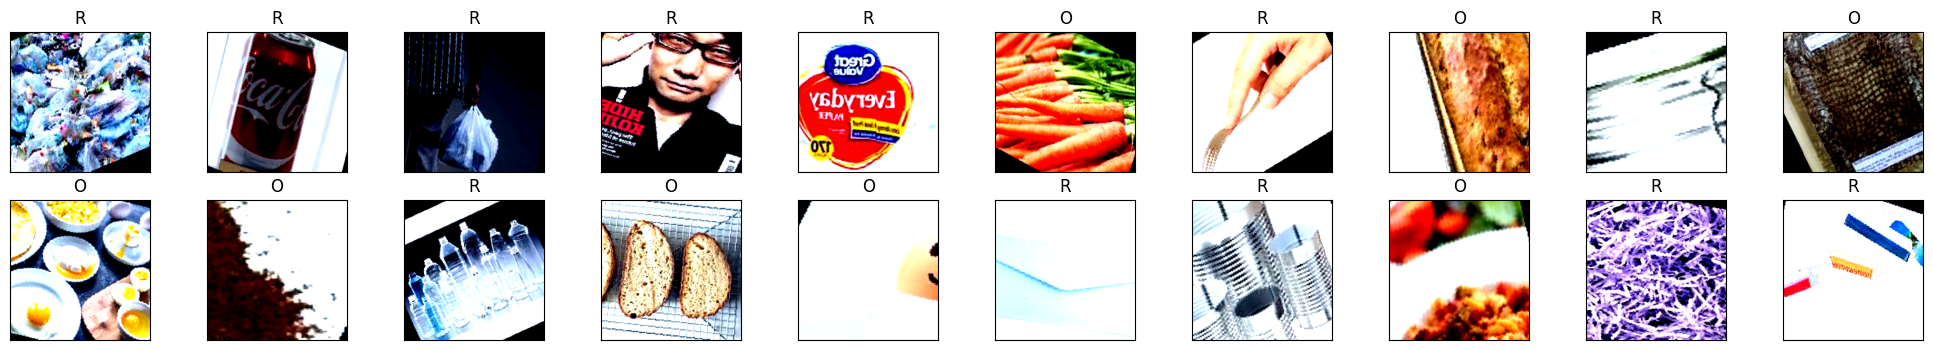

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20//2, idx+1, xticks = [], yticks = [])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])

torch.Size([32, 3, 224, 224])
tensor(0)


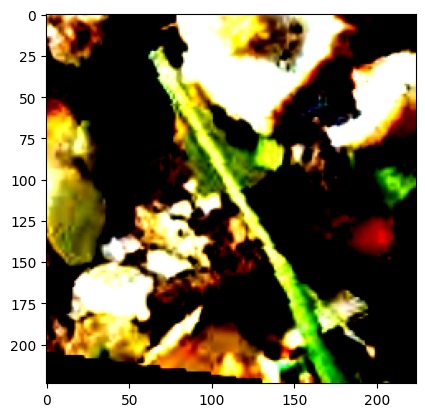

In [12]:
batch = next(iter(train_loader))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

In [14]:
model = models.densenet121(pretrained = True)
model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 85.9MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [15]:
model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for param in model.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(1024,256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2))

In [17]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003, weight_decay=0.0001)

In [19]:
for param in model.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [20]:
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [21]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
  loss_hist_train = [0.0] * num_epochs
  accuracy_hist_train=[0.0]*num_epochs
  loss_hist_valid=[0.0]*num_epochs
  accuracy_hist_valid=[0.0]*num_epochs
  train_size = sum(len(batch[1]) for batch in train_loader)
  val_size = sum(len(batch[1]) for batch in valid_loader)
  for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0.0, 0.0
    valid_loss, valid_correct = 0.0, 0.0
    for image, label in train_loader:
      image, label = image.to(device), label.to(device)
      pred = model(image)
      loss = criterion(pred, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * label.size(0)
      preds = torch.argmax(pred, dim = 1)
      train_correct += (preds == label).sum().item()

    train_loss /= train_size
    train_acc = train_correct / train_size
    loss_hist_train[epoch] = train_loss
    accuracy_hist_train[epoch] = train_acc

    model.eval()
    with torch.no_grad():
      for image, label in valid_loader:
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        valid_loss += loss.item() * label.size(0)
        valid_correct += (torch.argmax(pred, dim = 1) == label).sum().item()

      valid_loss /= val_size
      valid_acc = valid_correct / val_size
      loss_hist_valid[epoch] = valid_loss
      accuracy_hist_valid[epoch] = valid_acc
      print(f"Epoch {epoch+1}/{num_epochs} - "
          f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
          f"val_loss: {valid_loss:.4f} - val_acc: {valid_acc:.4f}")
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train_model(model, train_loader = train_loader, valid_loader=valid_loader,criterion=criterion, optimizer=optimizer, num_epochs=20)

Epoch 1/20 - loss: 0.3027 - acc: 0.8792 - val_loss: 0.2212 - val_acc: 0.9134
Epoch 2/20 - loss: 0.2660 - acc: 0.8920 - val_loss: 0.2086 - val_acc: 0.9176
Epoch 3/20 - loss: 0.2503 - acc: 0.8994 - val_loss: 0.2354 - val_acc: 0.9063
Epoch 4/20 - loss: 0.2454 - acc: 0.9027 - val_loss: 0.2017 - val_acc: 0.9238
Epoch 5/20 - loss: 0.2412 - acc: 0.9053 - val_loss: 0.2015 - val_acc: 0.9218
Epoch 6/20 - loss: 0.2340 - acc: 0.9093 - val_loss: 0.2032 - val_acc: 0.9229
Epoch 7/20 - loss: 0.2315 - acc: 0.9091 - val_loss: 0.2054 - val_acc: 0.9236
Epoch 8/20 - loss: 0.2359 - acc: 0.9076 - val_loss: 0.1920 - val_acc: 0.9231
Epoch 9/20 - loss: 0.2337 - acc: 0.9103 - val_loss: 0.1881 - val_acc: 0.9313
Epoch 10/20 - loss: 0.2192 - acc: 0.9135 - val_loss: 0.1841 - val_acc: 0.9293
Epoch 11/20 - loss: 0.2259 - acc: 0.9113 - val_loss: 0.1856 - val_acc: 0.9260
Epoch 12/20 - loss: 0.2199 - acc: 0.9136 - val_loss: 0.1939 - val_acc: 0.9267
Epoch 13/20 - loss: 0.2278 - acc: 0.9116 - val_loss: 0.2088 - val_acc: 0.

In [29]:
def plot_learning_curves(loss_train, loss_val, acc_train, acc_val):
    """
    Plots training & validation loss and accuracy.

    Args:
        loss_train: list of training losses
        loss_val: list of validation losses
        acc_train: list of training accuracies
        acc_val: list of validation accuracies
    """
    # Convert tensors to floats if needed
    acc_train = [x.item() if hasattr(x, 'item') else x for x in acc_train]
    acc_val   = [x.item() if hasattr(x, 'item') else x for x in acc_val]

    epochs = range(1, len(loss_train)+1)

    fig, axs = plt.subplots(1, 2, figsize=(16,5))

    # --- Loss subplot ---
    axs[0].plot(epochs, loss_train, marker='o', linestyle='-', color='blue', label='Train Loss')
    axs[0].plot(epochs, loss_val, marker='s', linestyle='--', color='orange', label='Validation Loss')
    axs[0].set_title('Loss per Epoch', fontsize=16)
    axs[0].set_xlabel('Epoch', fontsize=14)
    axs[0].set_ylabel('Loss', fontsize=14)
    axs[0].grid(True, linestyle='--', alpha=0.5)
    axs[0].legend(fontsize=12)

    # --- Accuracy subplot ---
    axs[1].plot(epochs, acc_train, marker='o', linestyle='-', color='blue', label='Train Accuracy')
    axs[1].plot(epochs, acc_val, marker='s', linestyle='--', color='orange', label='Validation Accuracy')
    axs[1].set_title('Accuracy per Epoch', fontsize=16)
    axs[1].set_xlabel('Epoch', fontsize=14)
    axs[1].set_ylabel('Accuracy', fontsize=14)
    axs[1].set_xticks(epochs)
    axs[1].set_ylim(0, 1)
    axs[1].grid(True, linestyle='--', alpha=0.5)
    axs[1].legend(fontsize=12)

    plt.tight_layout()
    plt.show()

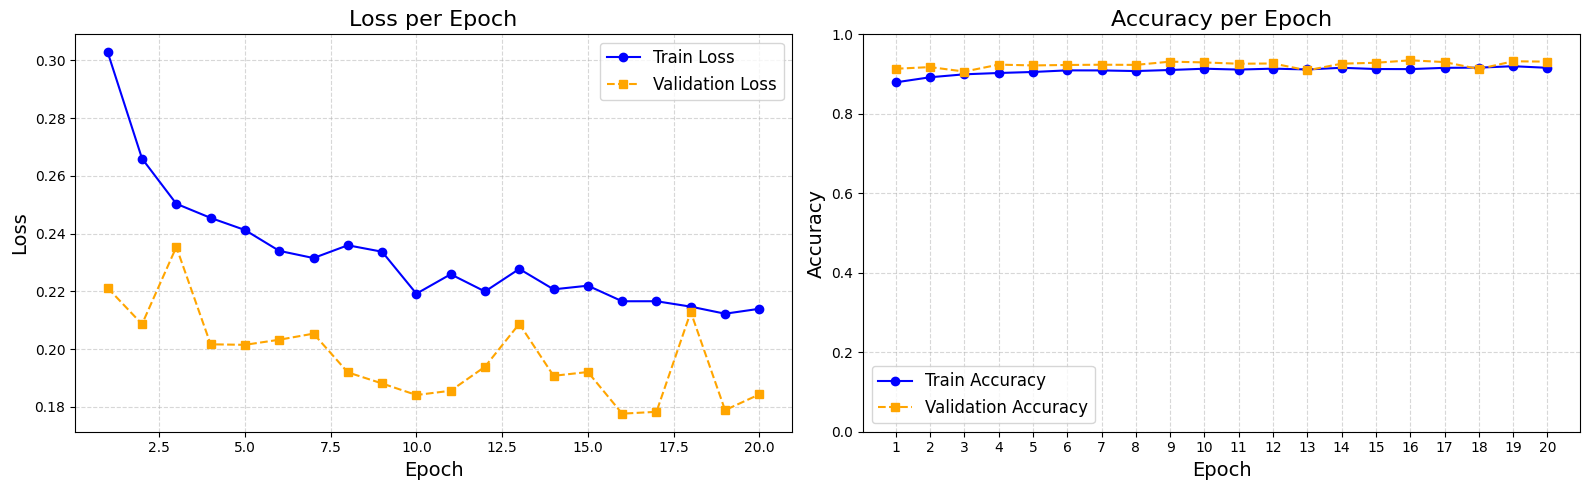

In [ ]:
plot_learning_curves(loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid)

In [33]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss, test_correct = 0.0, 0.0
    test_size = sum(len(batch[1]) for batch in test_loader)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            test_correct += (preds == labels).sum().item()

    test_loss /= test_size
    test_acc = test_correct / test_size
    print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")
    return test_loss, test_acc


In [ ]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

Test Loss: 0.1990 - Test Accuracy: 0.9160


#Visualize the results

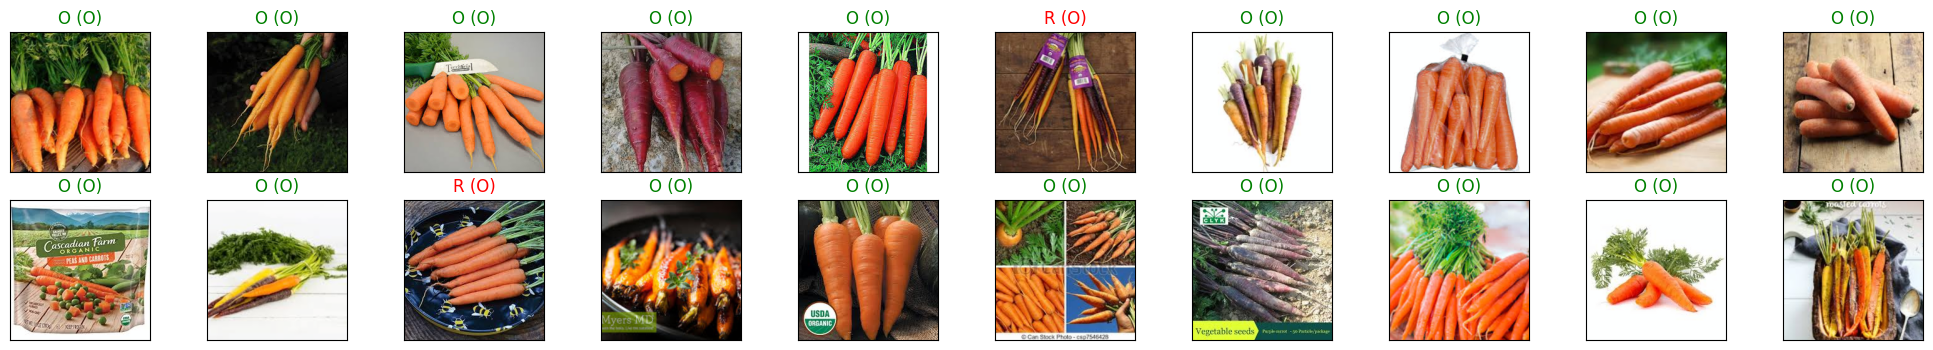

In [ ]:
# Get one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
output = model(images)
_, preds_tensor = torch.max(output, 1)

# Move predictions and labels back to CPU for visualization
preds = preds_tensor.cpu().numpy()
labels = labels.cpu().numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])

    img = images.cpu()[idx]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(f"{classes[preds[idx]]} ({classes[labels[idx]]})",
                 color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()

# Unfreeze Dense Block 4 + Classifier

In [22]:
model2 = models.densenet121(pretrained = True)

for param in model2.parameters():
  param.requires_grad = False

for param in model2.features.denseblock4.parameters():
  param.requires_grad = True

model2.classifier = nn.Sequential(nn.Linear(1024,256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2))
for param in model2.classifier.parameters():
    param.requires_grad = True

model2 = model2.to(device)

for param in model2.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {"params": model2.features.denseblock4.parameters(), "lr": 1e-4},
    {"params": model2.classifier.parameters(), "lr": 1e-3}
])


In [26]:
def train_model_saving_weights(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
  loss_hist_train = [0.0] * num_epochs
  accuracy_hist_train=[0.0]*num_epochs
  loss_hist_valid=[0.0]*num_epochs
  accuracy_hist_valid=[0.0]*num_epochs
  best_val_acc = 0.0
  train_size = sum(len(batch[1]) for batch in train_loader)
  val_size = sum(len(batch[1]) for batch in valid_loader)
  for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0.0, 0.0
    valid_loss, valid_correct = 0.0, 0.0
    for image, label in train_loader:
      image, label = image.to(device), label.to(device)
      pred = model(image)
      loss = criterion(pred, label)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * label.size(0)
      preds = torch.argmax(pred, dim = 1)
      train_correct += (preds == label).sum().item()

    train_loss /= train_size
    train_acc = train_correct / train_size
    loss_hist_train[epoch] = train_loss
    accuracy_hist_train[epoch] = train_acc

    model.eval()
    with torch.no_grad():
      for image, label in valid_loader:
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = criterion(pred, label)
        valid_loss += loss.item() * label.size(0)
        valid_correct += (torch.argmax(pred, dim = 1) == label).sum().item()

      valid_loss /= val_size
      valid_acc = valid_correct / val_size
      loss_hist_valid[epoch] = valid_loss
      accuracy_hist_valid[epoch] = valid_acc

      if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        save_path = f"best_model_epoch{epoch+1}_valacc{valid_acc:.4f}.pt"
        torch.save(model.state_dict(), save_path)
      print(f"Epoch {epoch+1}/{num_epochs} - "
          f"loss: {train_loss:.4f} - acc: {train_acc:.4f} - "
          f"val_loss: {valid_loss:.4f} - val_acc: {valid_acc:.4f}")
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [27]:
loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid = train_model_saving_weights(
    model2, train_loader, valid_loader, criterion, optimizer, num_epochs=20
)

Epoch 1/20 - loss: 0.1870 - acc: 0.9294 - val_loss: 0.1607 - val_acc: 0.9393
Epoch 2/20 - loss: 0.1723 - acc: 0.9339 - val_loss: 0.1516 - val_acc: 0.9413
Epoch 3/20 - loss: 0.1657 - acc: 0.9366 - val_loss: 0.1532 - val_acc: 0.9386
Epoch 4/20 - loss: 0.1506 - acc: 0.9421 - val_loss: 0.1608 - val_acc: 0.9406
Epoch 5/20 - loss: 0.1503 - acc: 0.9421 - val_loss: 0.1485 - val_acc: 0.9457
Epoch 6/20 - loss: 0.1372 - acc: 0.9469 - val_loss: 0.1624 - val_acc: 0.9419
Epoch 7/20 - loss: 0.1297 - acc: 0.9515 - val_loss: 0.1526 - val_acc: 0.9419
Epoch 8/20 - loss: 0.1267 - acc: 0.9507 - val_loss: 0.1343 - val_acc: 0.9477
Epoch 9/20 - loss: 0.1216 - acc: 0.9540 - val_loss: 0.1383 - val_acc: 0.9448
Epoch 10/20 - loss: 0.1195 - acc: 0.9549 - val_loss: 0.1326 - val_acc: 0.9521
Epoch 11/20 - loss: 0.1104 - acc: 0.9579 - val_loss: 0.1521 - val_acc: 0.9435
Epoch 12/20 - loss: 0.1127 - acc: 0.9571 - val_loss: 0.1521 - val_acc: 0.9439
Epoch 13/20 - loss: 0.1081 - acc: 0.9580 - val_loss: 0.1464 - val_acc: 0.

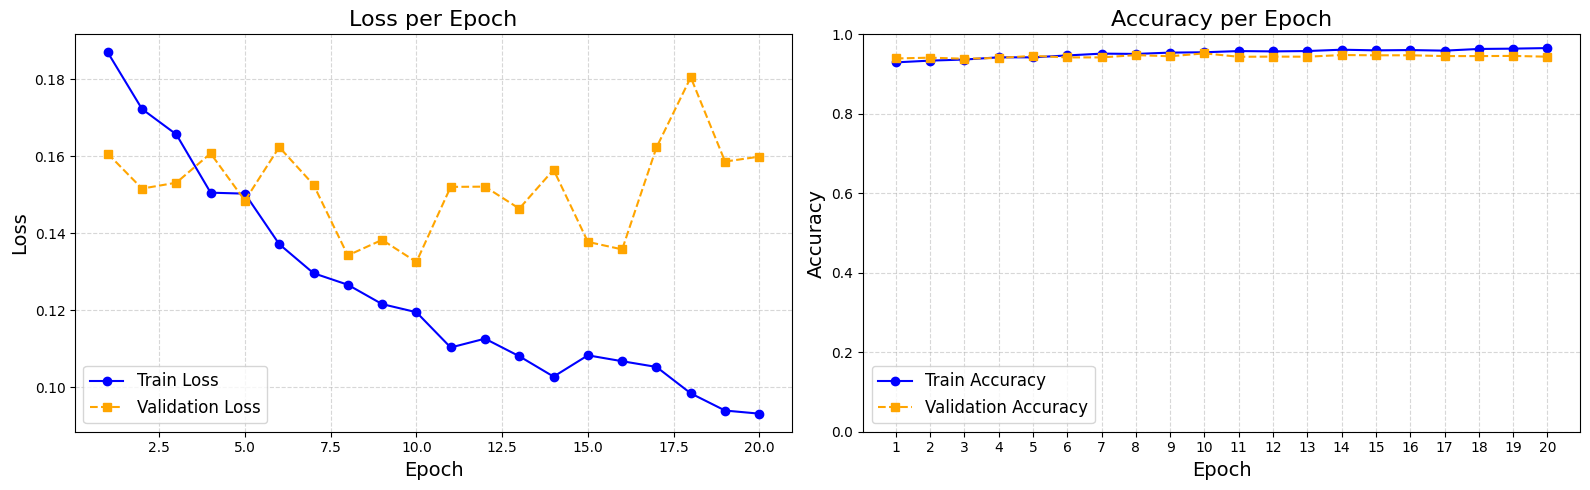

In [31]:
plot_learning_curves(loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid)

In [36]:
best_model = models.densenet121(pretrained = False)
best_model.classifier = nn.Sequential(nn.Linear(1024,256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2))
best_model.load_state_dict(torch.load("/content/best_model_epoch10_valacc0.9521.pt", map_location=device))
best_model.to(device)
best_model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [37]:
test_loss, test_acc = evaluate_model(best_model, test_loader, criterion, device)

Test Loss: 0.2059 - Test Accuracy: 0.9335


In [35]:
total_params = sum(p.numel() for p in model2.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 7216770


## As we saw training our model for 20 epochs made it start to overfit the test results was 0.89 or 0.88 can't recall perfectly, after using the model weights in the 10th epoch the best result, we got Train Accuracy of  :95.49 %  Validation Accuracy of : 95.21 % and Test Accuracy of : 93.35 %  

# Thank you!